In [1]:
from scipy.spatial import cKDTree
import numpy as np
import holoviews as hv
hv.notebook_extension('matplotlib')

In [2]:
# set number of particles, particle radius, size of box
n, r, size = 100, 2, 100
# set initial positions
pos = np.random.uniform(r, size-r, size=(n,2))
# set masses
m = np.ones(n)
# set velocities
vx = np.random.uniform(-1,1,size=n)
vy = np.sqrt(1 - vx**2)
y_negative = np.random.choice([True, False], n) 
vy[y_negative] = -vy[y_negative]
vel = np.sqrt(vx**2 + vy**2)

def update(i, pos, vx, vy, dt=0.1, r=r):
    # make k-d tree of positions and query for all pairs within 2r
    tree = cKDTree(pos)
    collision_pairs = tree.query_pairs(r=2*r)
    # iterate over indices of colliding pairs
    for i,j in collision_pairs:
        # calculate angle of collision
        theta = np.arctan((pos[i,1] - pos[j,1])/(pos[i,0] - pos[j,0]))
        ctheta, stheta = np.cos(theta), np.sin(theta)
        # normal + tangential velocities
        vi_norm = vx[i]*ctheta + vy[i]*stheta
        vj_norm = vx[j]*ctheta + vy[j]*stheta
        vi_tan = vx[i]*stheta - vy[i]*ctheta
        vj_tan = vx[j]*stheta - vy[j]*ctheta
        vi_norm, vj_norm = m[j]*vj_norm/m[i], m[i]*vi_norm/m[j]
        vxi = vi_norm*ctheta + vi_tan*stheta
        vyi = vi_norm*stheta - vi_tan*ctheta
        vxj = vj_norm*ctheta + vj_tan*stheta
        vyj = vj_norm*stheta - vj_tan*ctheta
        # update velocities
        vx[i], vy[i] = vxi, vyi
        vx[j], vy[j] = vxj, vyj
    # find particles within r of box walls and reflect them
    bounce_x = (pos[:,0] <= r) | (pos[:,0] >= size-r)
    bounce_y = (pos[:,1] <= r) | (pos[:,1] >= size-r)
    vx[bounce_x] = -vx[bounce_x]
    vy[bounce_y] = -vy[bounce_y]
    # update positions within new velocities * timestep
    pos_new = pos + np.array([vx,vy]).T * dt
    return pos_new, vx, vy

# initialize dictionaries of position + velocity at timesteps
pos_dict = {0:pos}
vel_dict = {0:vel}
for i in range(1,501):
    pos, vx, vy = update(i, pos, vx, vy)
    vel = np.sqrt(vx**2 + vy**2)
    # select only every 5th iteration to avoid huge notebook
    if i % 5 == 0: 
        pos_dict[i] = pos
        vel_dict[i] = vel

In [3]:
# make dictionary of plots for slider
pos_dict_hv = {i:hv.Scatter((p[:,0], p[:,1])) for i,p in pos_dict.items()}
vel_dict_hv = {i:hv.Histogram((np.histogram(v, bins=np.linspace(0,3,15)))) for i,v in vel_dict.items()}

:HoloMap   [Timestep]
   :Scatter   [x]   (y)
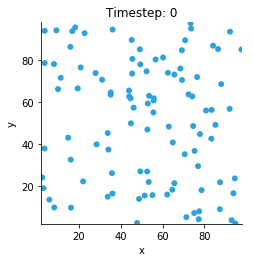
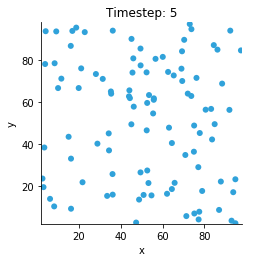
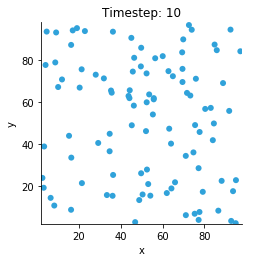
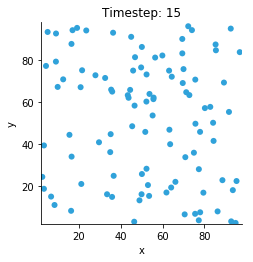
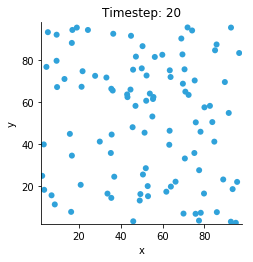
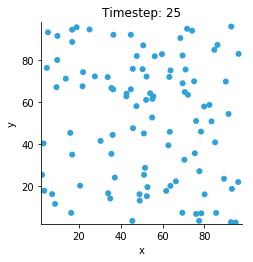
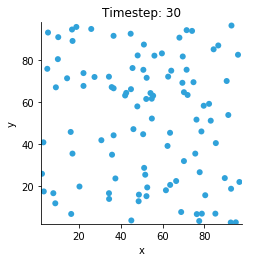
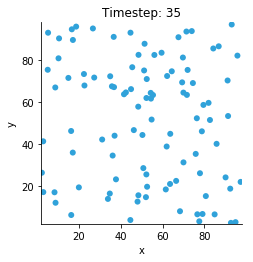
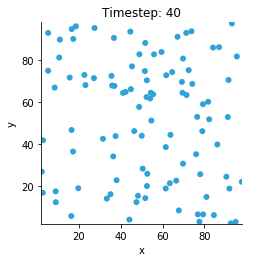
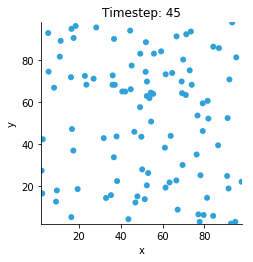
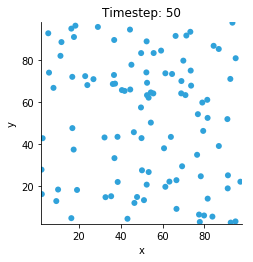
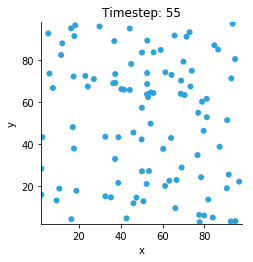
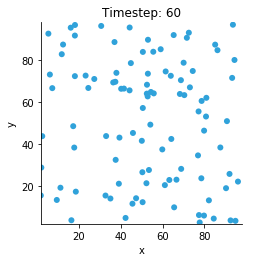
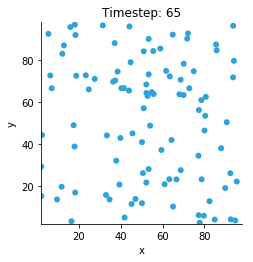
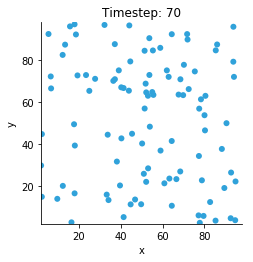
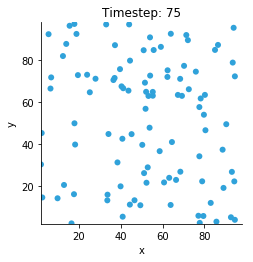
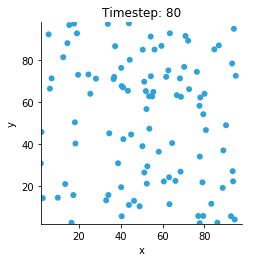
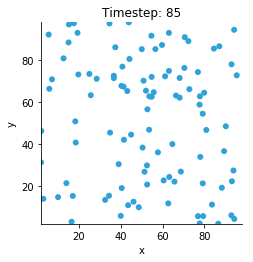
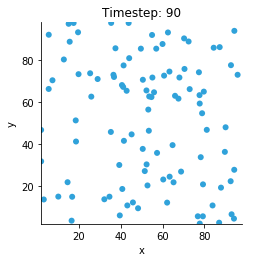
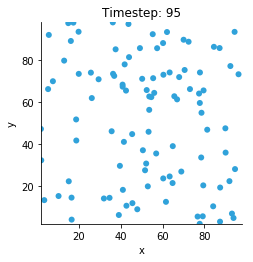
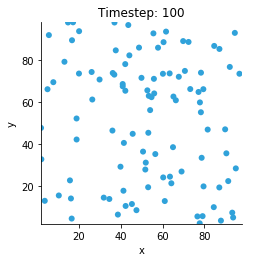
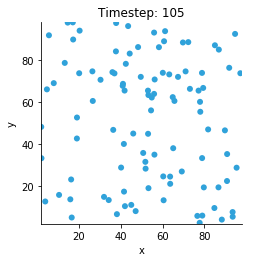
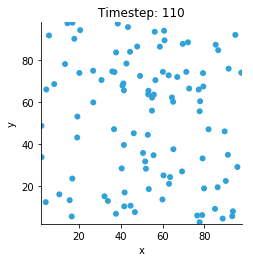
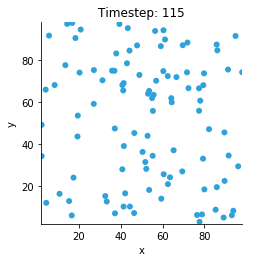
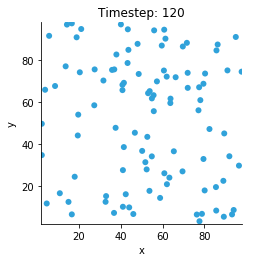
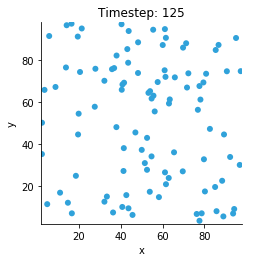
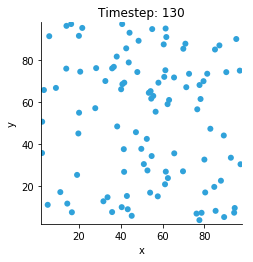
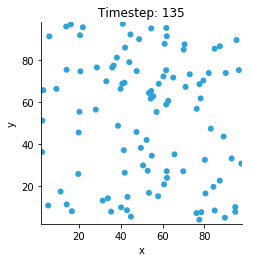
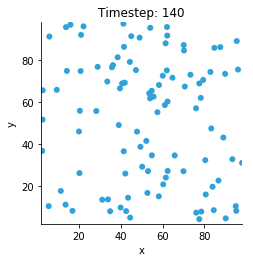
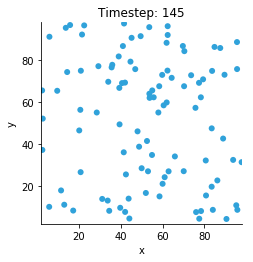
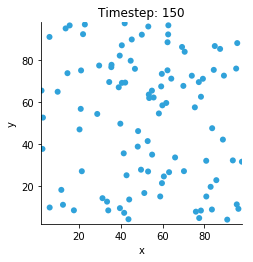
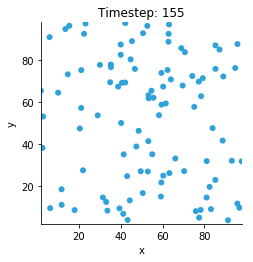
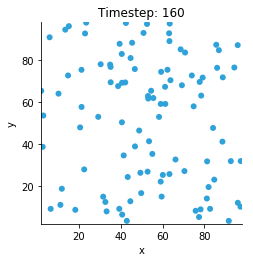
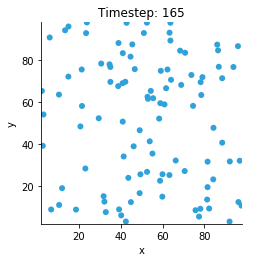
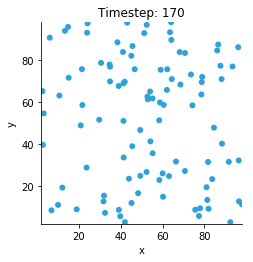
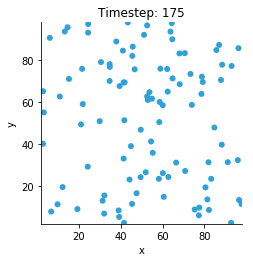
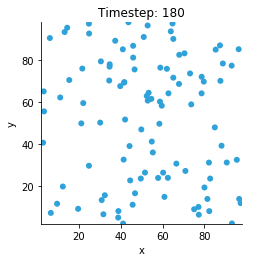
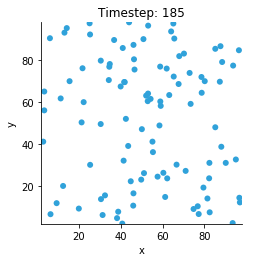
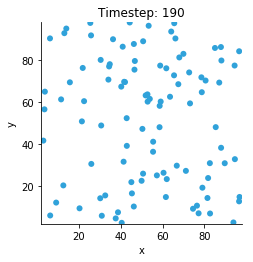
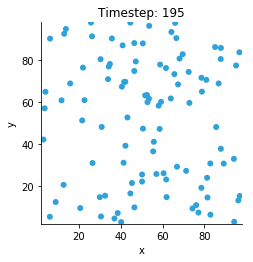
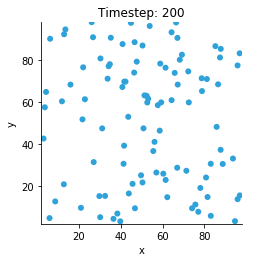
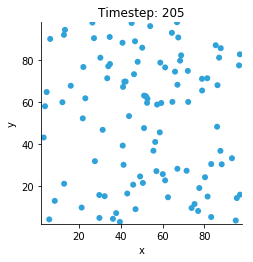
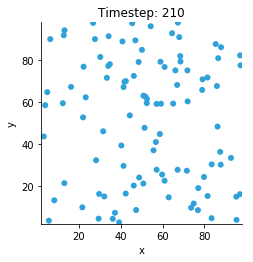
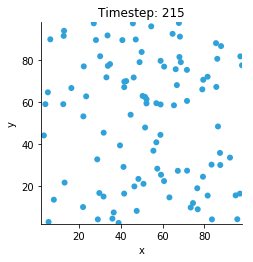
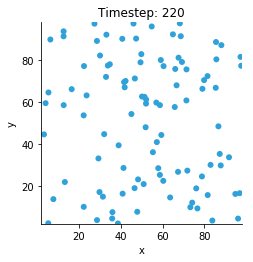
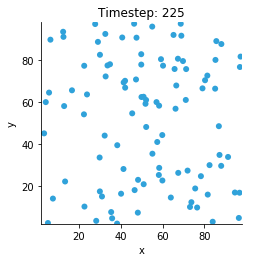
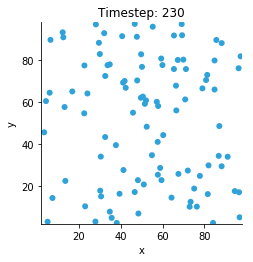
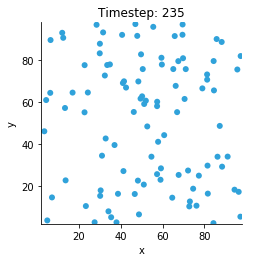
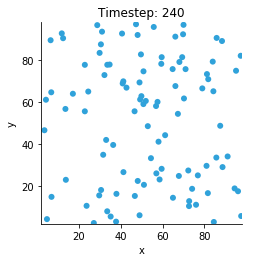
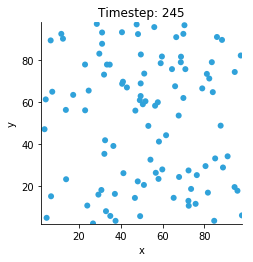
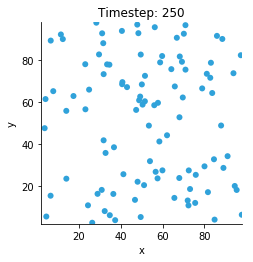
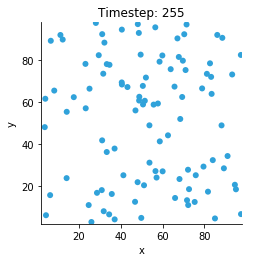
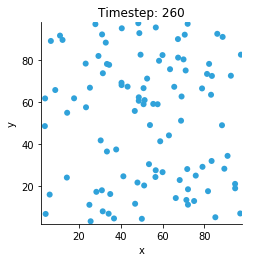
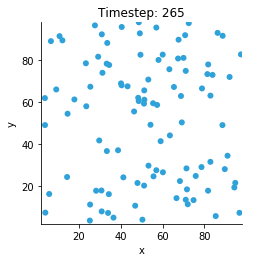
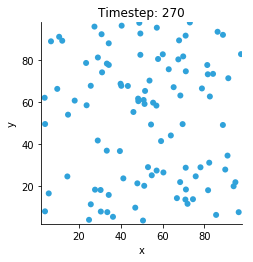
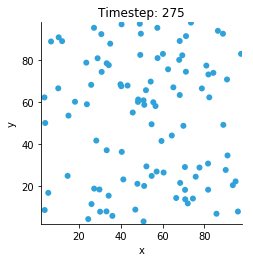
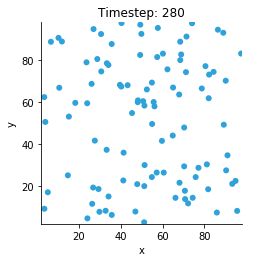
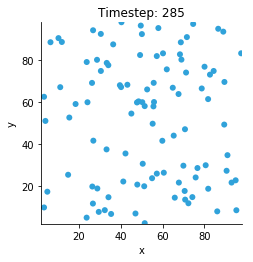
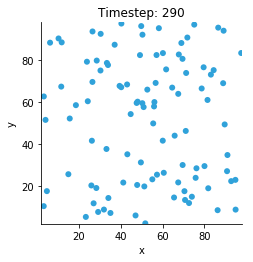
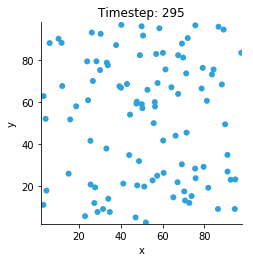
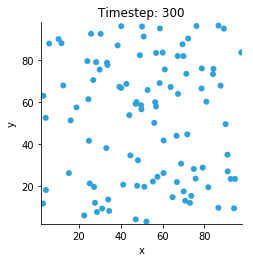
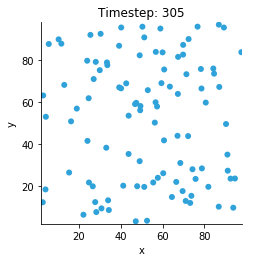
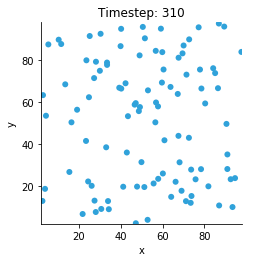
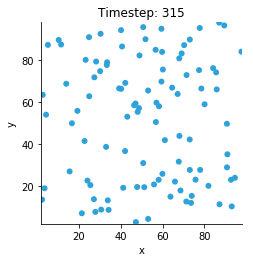
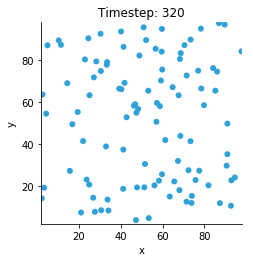
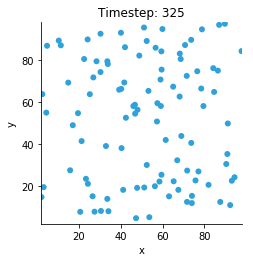
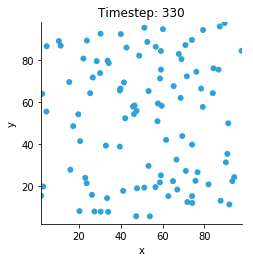
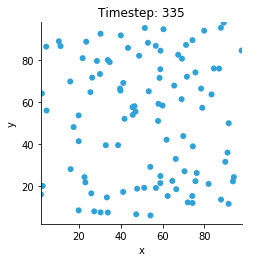
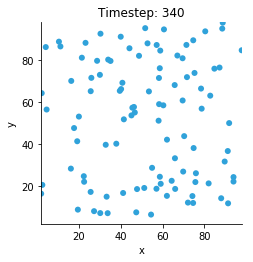
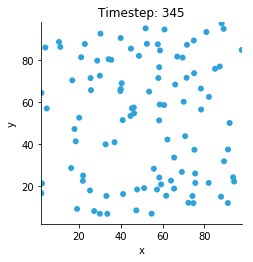
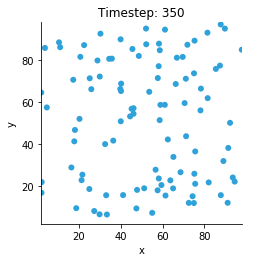
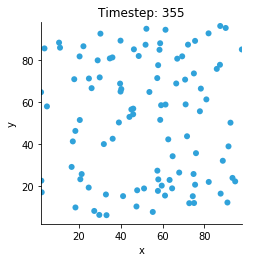
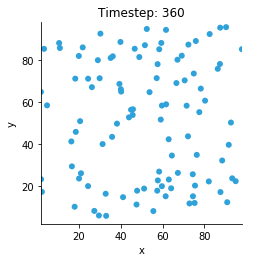
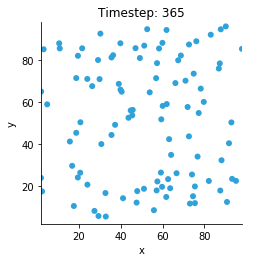
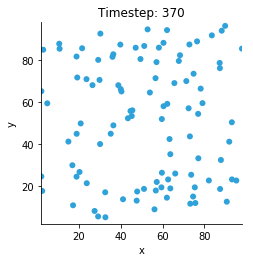
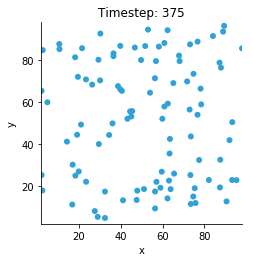
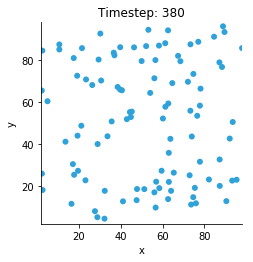
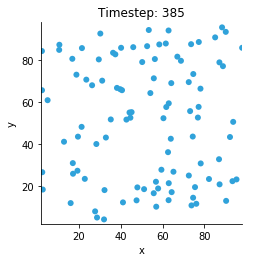
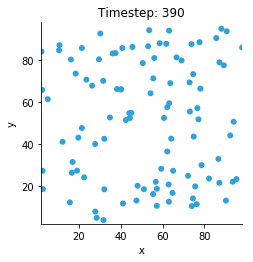
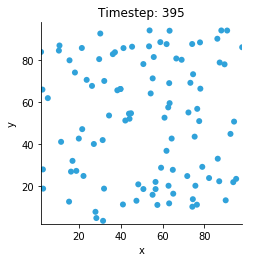
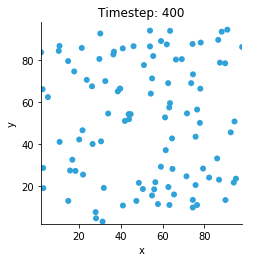
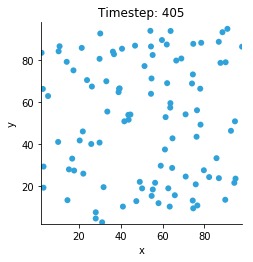
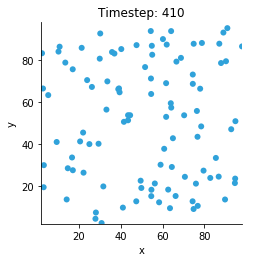
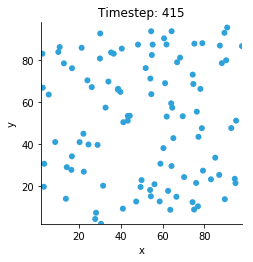
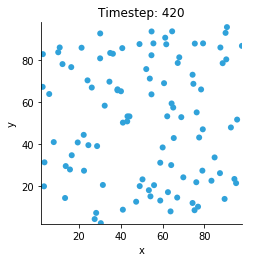
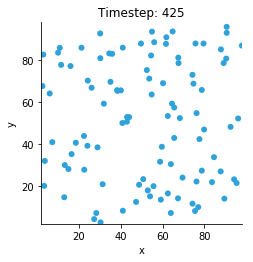
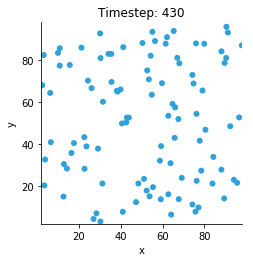
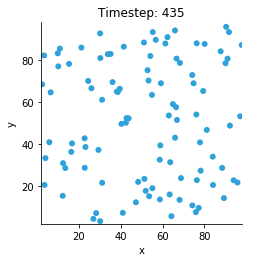
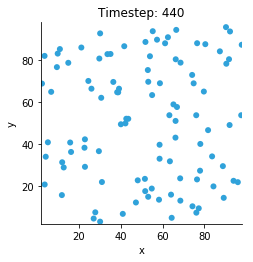
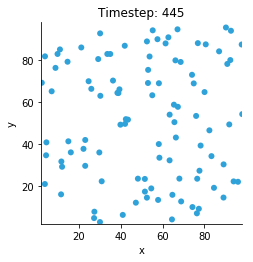
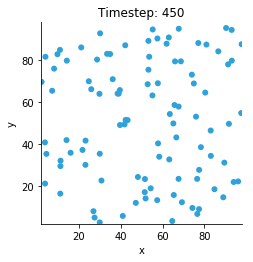
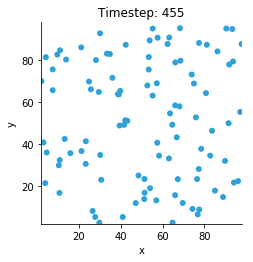
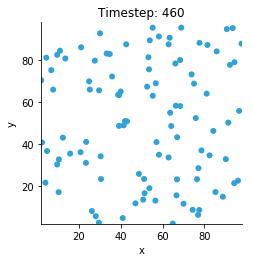
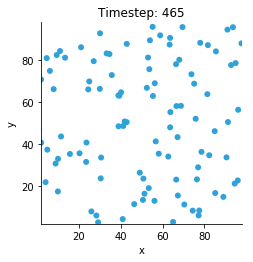
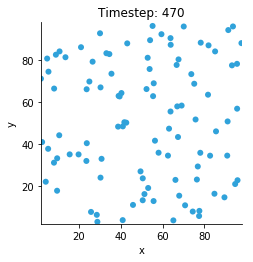
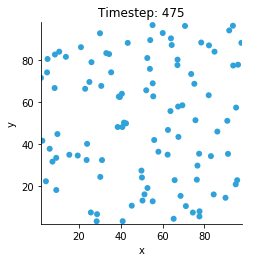
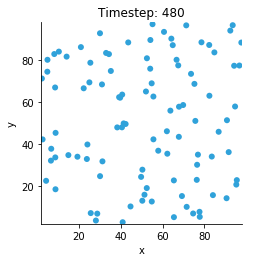
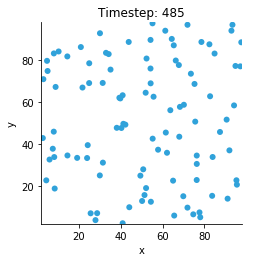
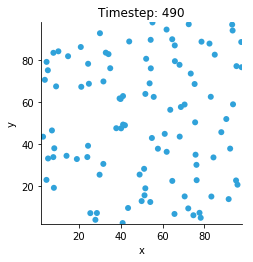
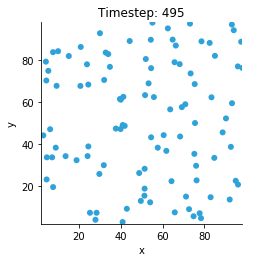
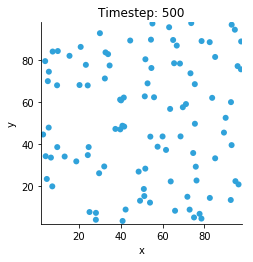

In [4]:
# position slider plot
pos_hmap = hv.HoloMap(pos_dict_hv, kdims='Timestep')
pos_hmap

:HoloMap   [Timestep]
   :Histogram   [x]   (Frequency)
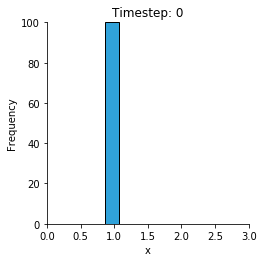
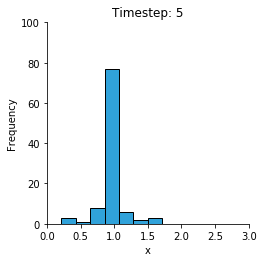
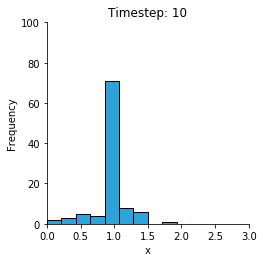
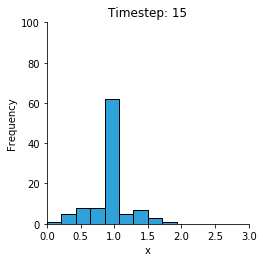
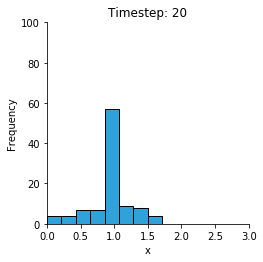
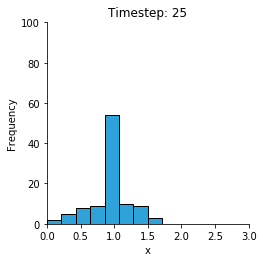
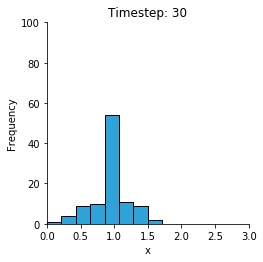
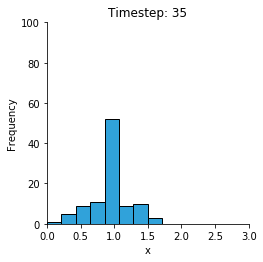
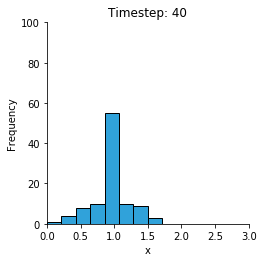
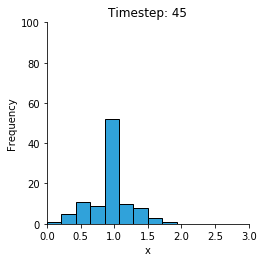
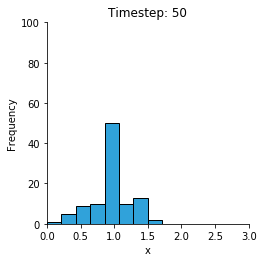
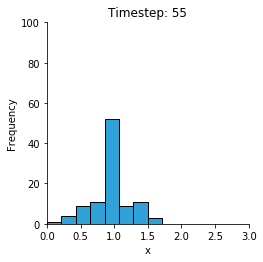
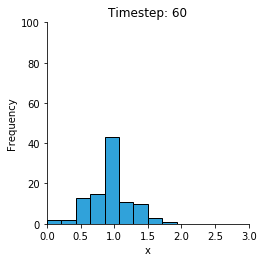
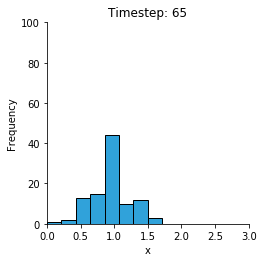
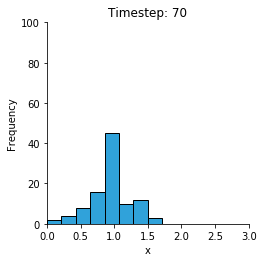
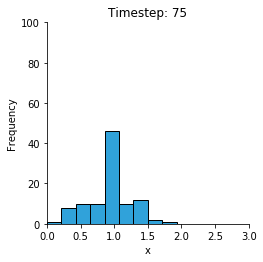
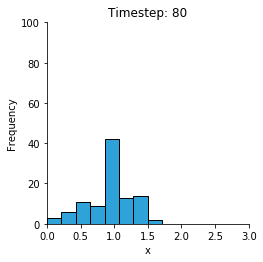
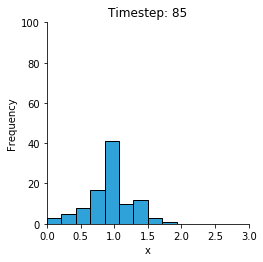
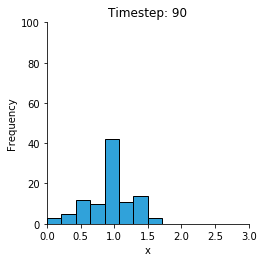
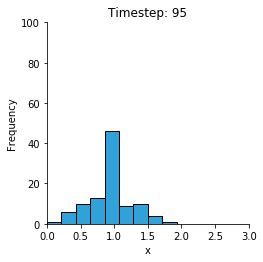
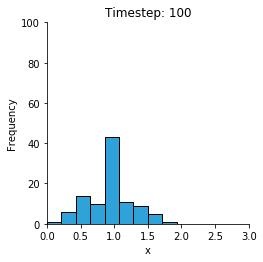
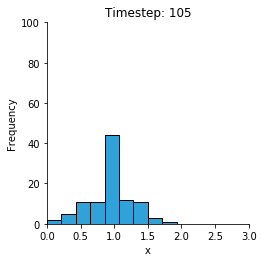
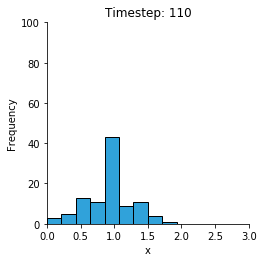
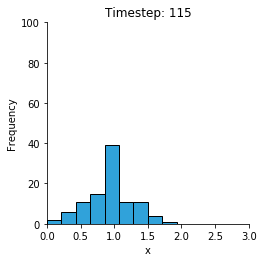
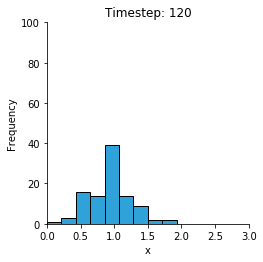
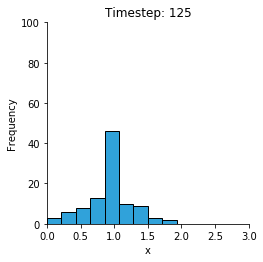
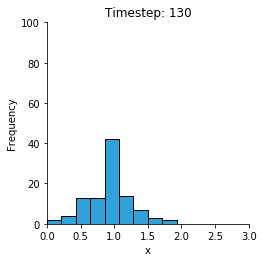
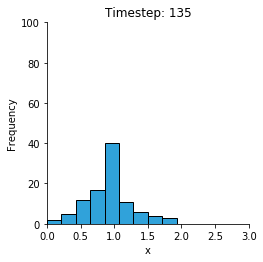
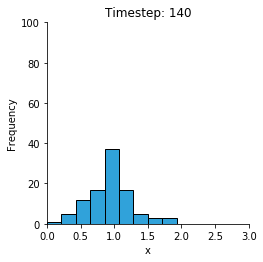
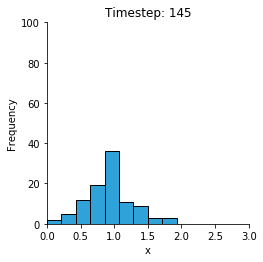
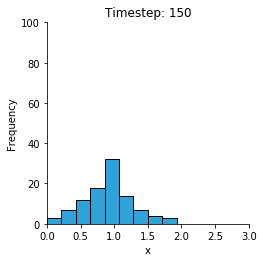
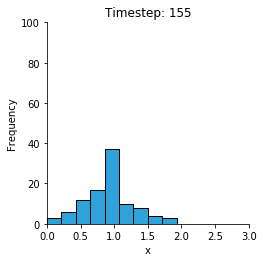
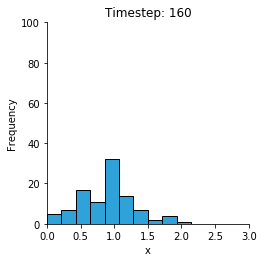
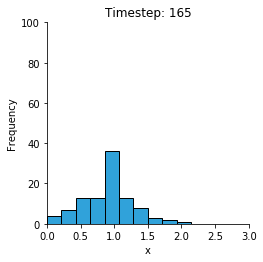
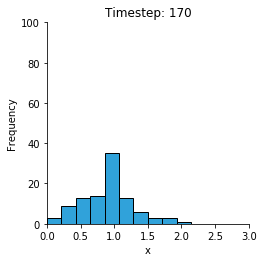
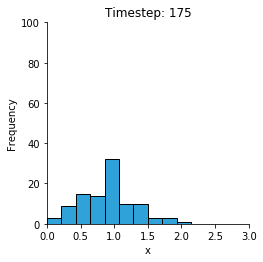
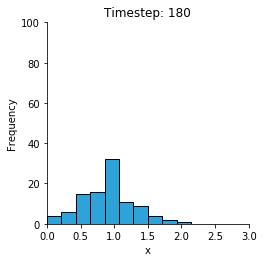
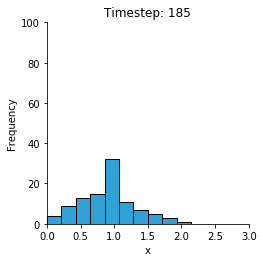
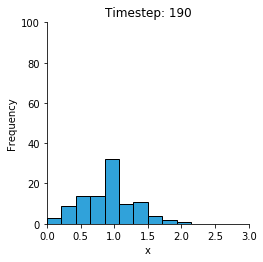
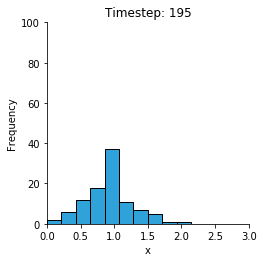
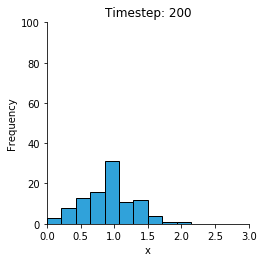
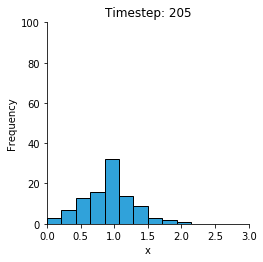
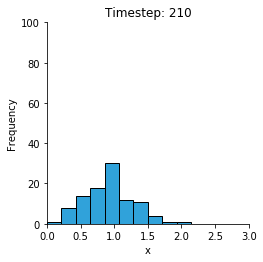
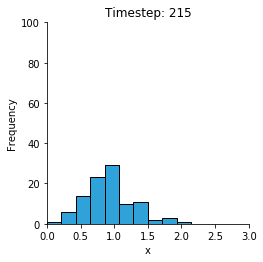
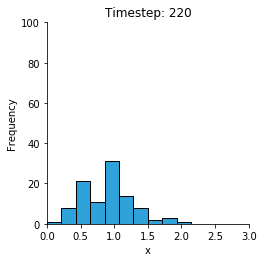
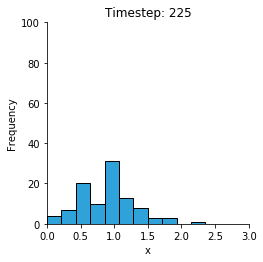
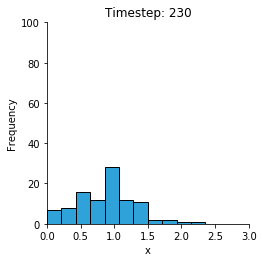
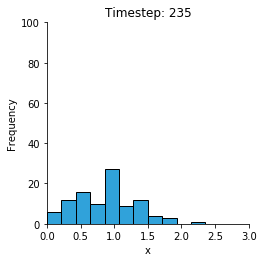
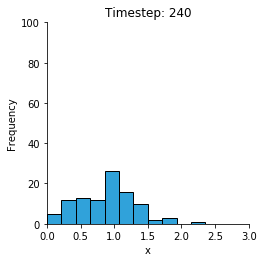
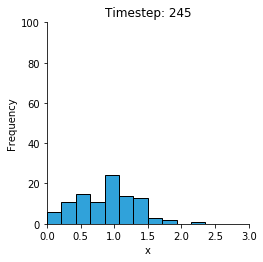
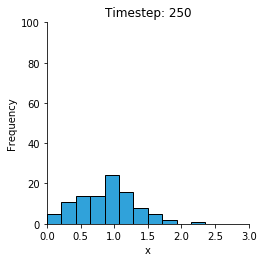
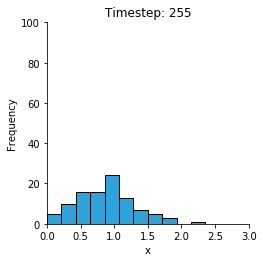
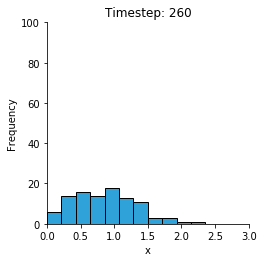
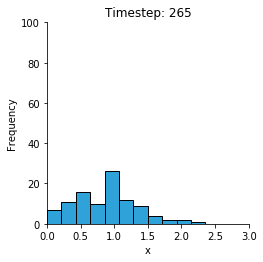
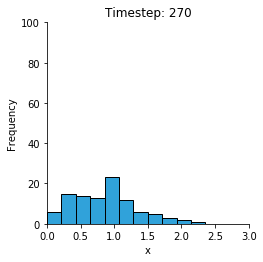
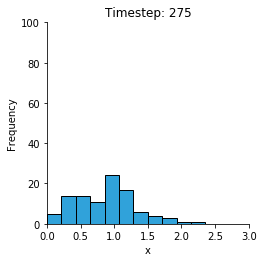
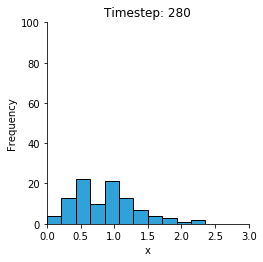
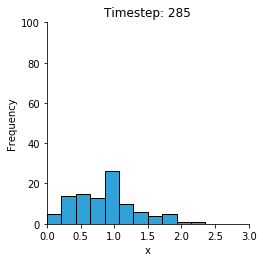
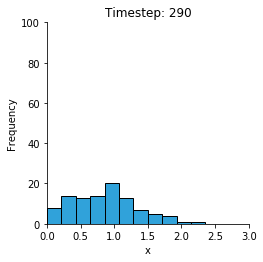
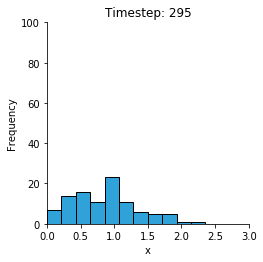
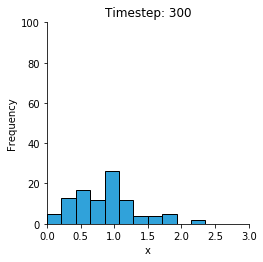
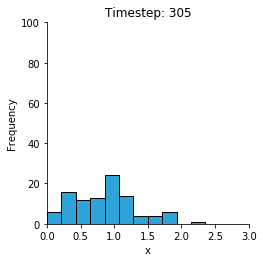
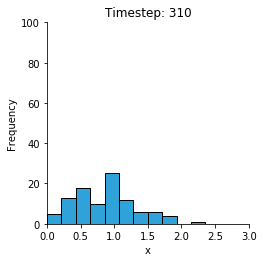
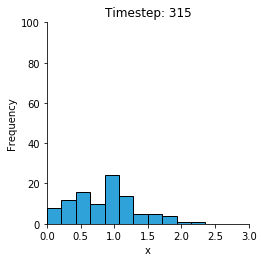
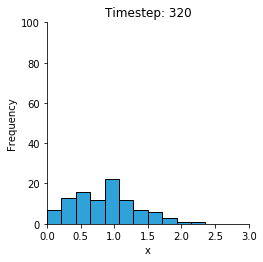
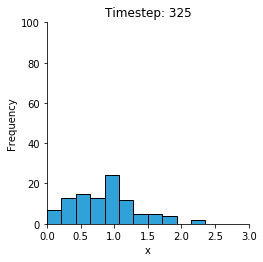
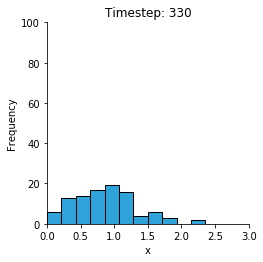
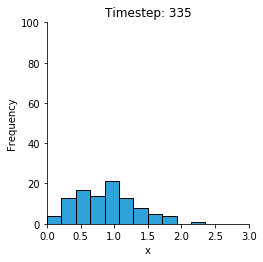
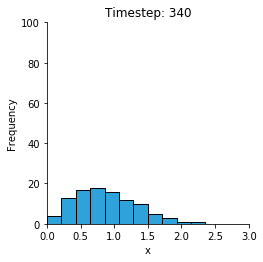
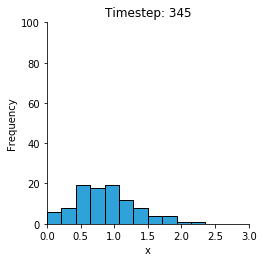
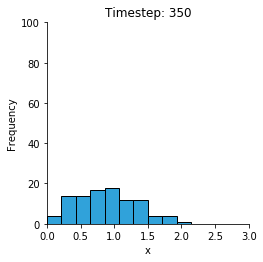
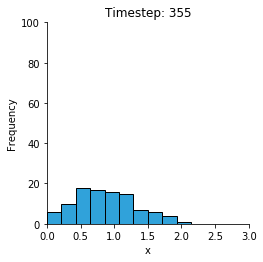
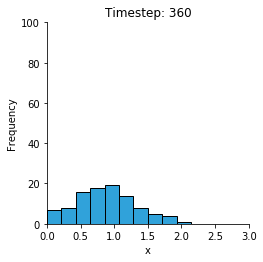
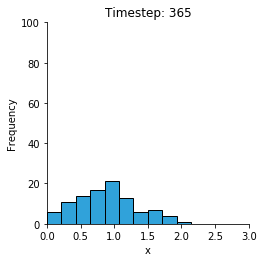
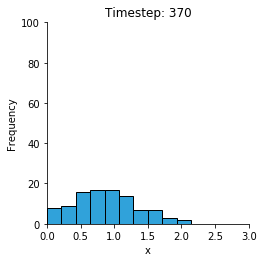
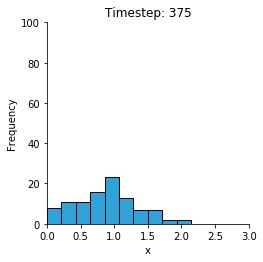
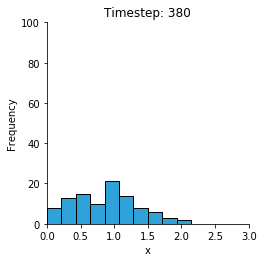
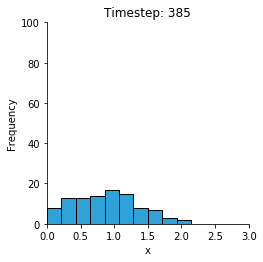
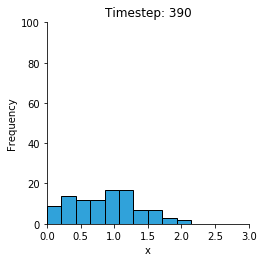
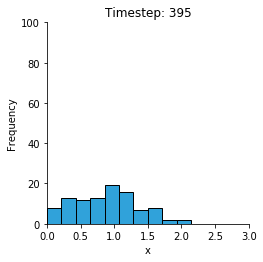
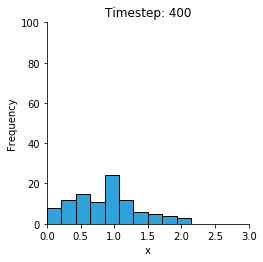
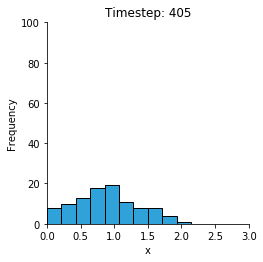
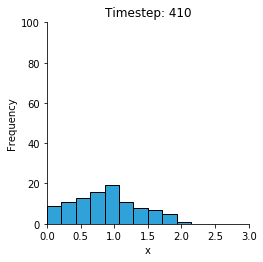
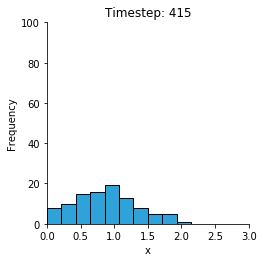
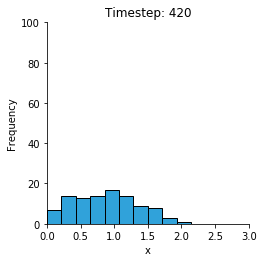
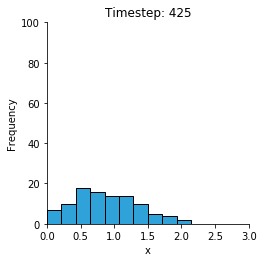
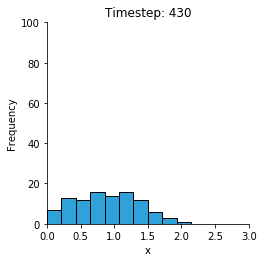
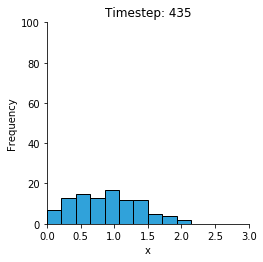
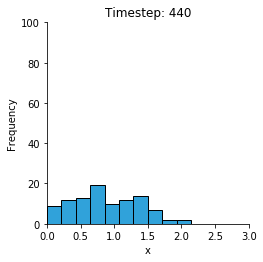
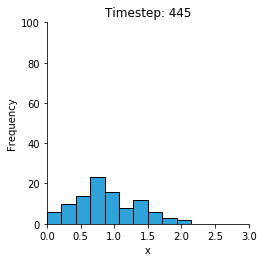
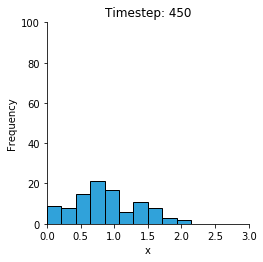
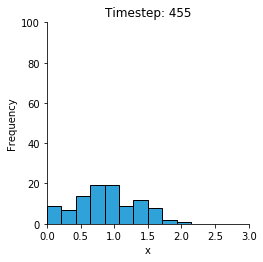
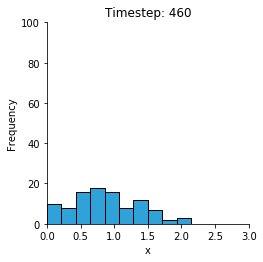
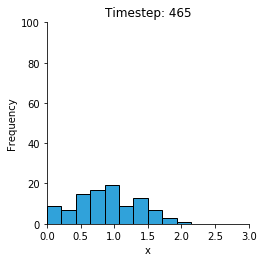
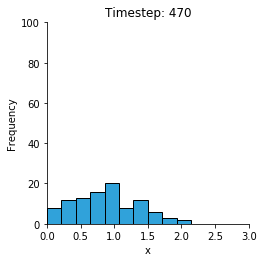
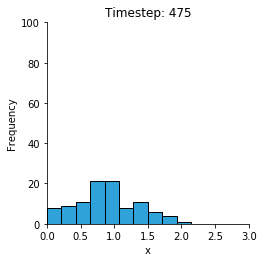
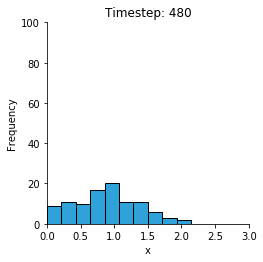
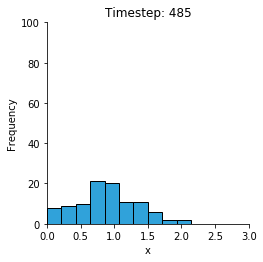
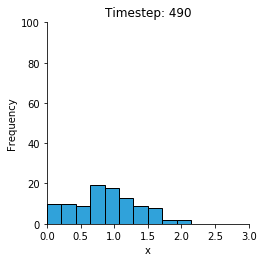
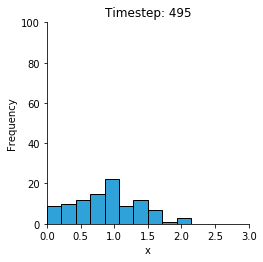
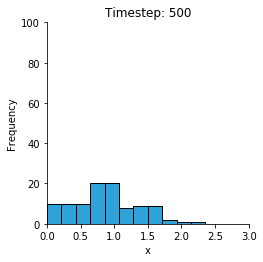

In [5]:
# velocity histogram slider plot
vel_hmap = hv.HoloMap(vel_dict_hv, kdims='Timestep')
vel_hmap

In [6]:
# set number of particles, particle radius, size of box
n, r, size = 100, 2, 100
# set initial positions
pos = np.random.uniform(r, size-r, size=(n,2))
# set masses
m = np.ones(n)
# set velocities
vx = np.random.uniform(-1,1,size=n)
vy = np.sqrt(1 - vx**2)
y_negative = np.random.choice([True, False], n) 
vy[y_negative] = -vy[y_negative]
vel = np.sqrt(vx**2 + vy**2)

#pos_all = np.array([])
vel_all = np.array([])
for j in range(100):
    for i in range(1,501):
        pos, vx, vy = update(i, pos, vx, vy)
        vel = np.sqrt(vx**2 + vy**2)
        # select only every 5th iteration to avoid huge notebook
        if i % 500 == 0: 
            vel_all = np.concatenate([vel_all, vel])

In [7]:
%config InlineBackend.figure_format='retina'
import seaborn as sns
sns.set(style='white', font_scale=1.2)

In [8]:
x = np.linspace(0,3,1000)
def maxwellian(x,m=1):
    return 2*x*m*np.exp(-m*x**2)
y = maxwellian(x)

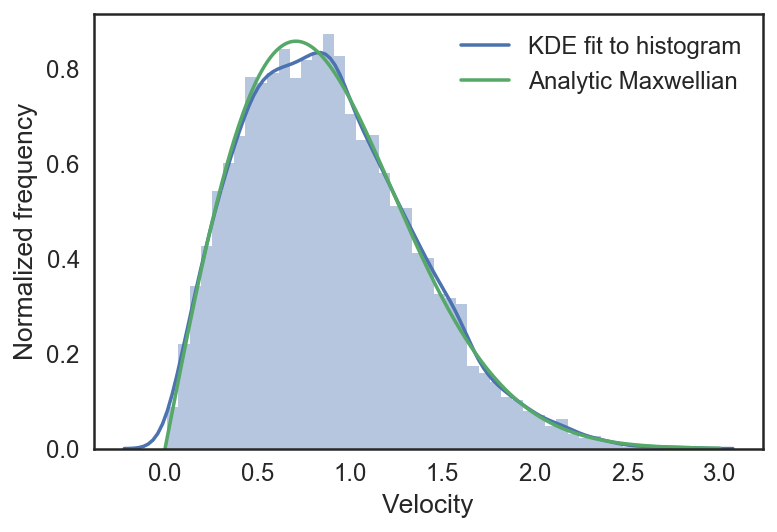

In [9]:
ax = sns.distplot(vel_all, kde_kws={'label':'KDE fit to histogram'})
ax.set_xlabel('Velocity')
ax.set_ylabel('Normalized frequency')
ax.plot(x,y, label='Analytic Maxwellian')
ax.legend()
ax.get_figure().savefig('maxwellian.png')
#plt.savefig('')

In [10]:
# set number of particles, particle radius, size of box
n, r, size = 100, 2, 100
# set initial positions
pos = np.random.uniform(r, size-r, size=(n,2))
# set masses
m = np.ones(n)
m[:int(n/2)] *= 10
# set velocities
vx = np.random.uniform(-1,1,size=n)
vy = np.sqrt(1 - vx**2)
y_negative = np.random.choice([True, False], n) 
vy[y_negative] = -vy[y_negative]
vel = np.sqrt(vx**2 + vy**2)

#pos_all = np.array([])
vel_all = np.array([])
for j in range(100):
    for i in range(1,501):
        pos, vx, vy = update(i, pos, vx, vy)
        vel = np.sqrt(vx**2 + vy**2)
        # select only every 5th iteration to avoid huge notebook
        if i % 500 == 0: 
            vel_all = np.concatenate([vel_all, vel])

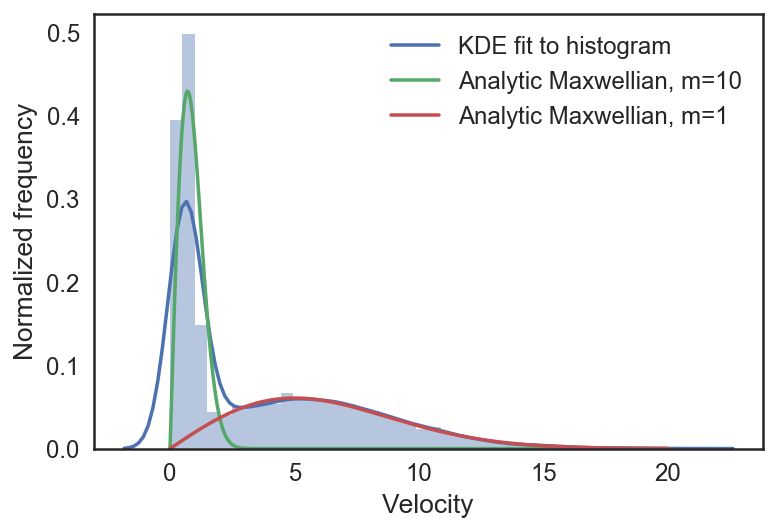

In [11]:
x = np.linspace(0, 20, 1000)
ax = sns.distplot(vel_all, kde_kws={'label':'KDE fit to histogram'})
ax.set_xlabel('Velocity')
ax.set_ylabel('Normalized frequency')
ax.plot(x,maxwellian(x)/2, label='Analytic Maxwellian, m=10')
ax.plot(x,maxwellian(x,m=0.02)/2, label='Analytic Maxwellian, m=1')
ax.legend()
ax.get_figure().savefig('maxwellian_2.png')

In [30]:
def is_relaxed(vel, mfp, relaxed):
    derp = np.abs((np.percentile(vel, 50) - mfp)/mfp)
    if derp < 0.1:
        relaxed = True
    return relaxed

In [53]:
np.logspace(1,3,20).astype(int)

array([  10,   12,   16,   20,   26,   33,   42,   54,   69,   88,  112,
        143,  183,  233,  297,  379,  483,  615,  784, 1000])

In [120]:
#pos_all = np.array([])
trel_n = []
for n in np.arange(25,520,25).astype(int):
    # set number of particles, particle radius, size of box
    r, size = 2, 100
    # set initial positions
    pos = np.random.uniform(r, size-r, size=(n,2))
    # set masses
    m = np.ones(n)
    # set velocities
    vx = np.random.uniform(-1,1,size=n)
    vy = np.sqrt(1 - vx**2)
    y_negative = np.random.choice([True, False], n) 
    vy[y_negative] = -vy[y_negative]
    vel = np.sqrt(vx**2 + vy**2)
    relaxed = False
    t = 0
    mfp = np.sqrt(np.log(2))
    while not relaxed:
        t += 0.1
        pos, vx, vy = update(i, pos, vx, vy)
        vel = np.sqrt(vx**2 + vy**2)
        relaxed = is_relaxed(vel, mfp, relaxed)
        if relaxed:
            trel_n.append([n/size**2,t])
            break

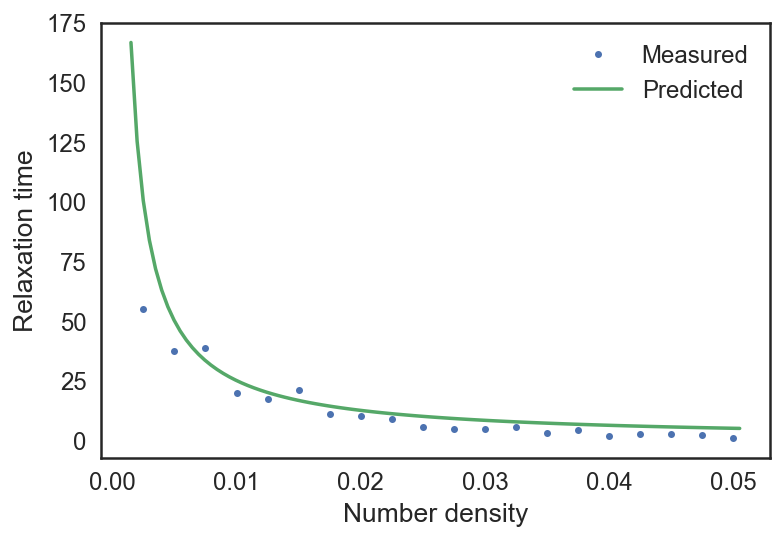

In [121]:
trel_n = np.array(trel_n)
x = np.linspace(trel_n[:,0].min()*0.6,trel_n[:,0].max()*1.01,100)
tau = 1/(x*4)
sns.mpl.pyplot.plot(*trel_n.T, '.', label='Measured')
sns.mpl.pyplot.plot(x,tau, '-', label='Predicted')
sns.mpl.pyplot.legend()
sns.mpl.pyplot.xlabel('Number density')
sns.mpl.pyplot.ylabel('Relaxation time')
sns.mpl.pyplot.savefig('trel_n.png')

In [122]:
#pos_all = np.array([])
trel = []
for r in [1,2,3,4,5,7,10,15]:
    # set number of particles, particle radius, size of box
    n, size = 100, 100
    # set initial positions
    pos = np.random.uniform(r, size-r, size=(n,2))
    # set masses
    m = np.ones(n)
    # set velocities
    vx = np.random.uniform(-1,1,size=n)
    vy = np.sqrt(1 - vx**2)
    y_negative = np.random.choice([True, False], n) 
    vy[y_negative] = -vy[y_negative]
    vel = np.sqrt(vx**2 + vy**2)
    relaxed = False
    t = 0
    mfp = np.sqrt(np.log(2))
    while not relaxed:
        t += 0.1
        pos, vx, vy = update(i, pos, vx, vy, r=r)
        vel = np.sqrt(vx**2 + vy**2)
        #print(r,np.percentile(vel,50))
        relaxed = is_relaxed(vel, mfp, relaxed)
        if relaxed:
            trel.append([r,t])
            break

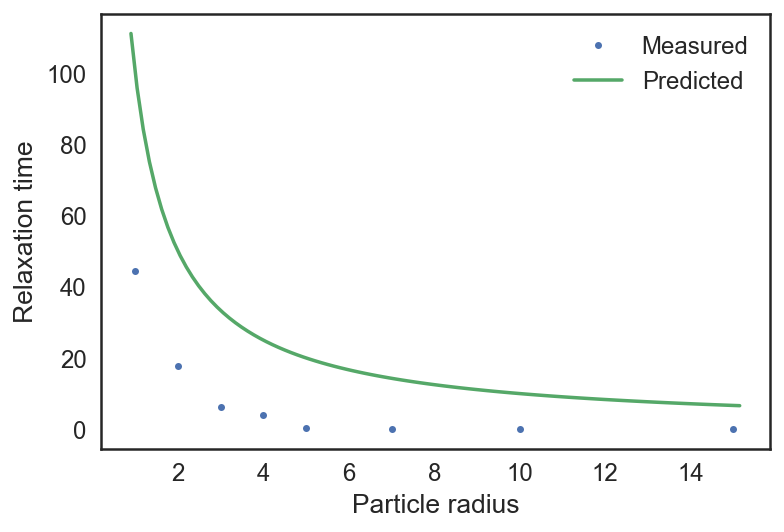

In [123]:
trel = np.array(trel)
x = np.linspace(trel[:,0].min()*0.9,trel[:,0].max()*1.01,100)
tau = 1/(x/100)
sns.mpl.pyplot.plot(*trel.T, '.', label='Measured')
sns.mpl.pyplot.plot(x,tau, '-', label='Predicted')
sns.mpl.pyplot.legend()
sns.mpl.pyplot.xlabel('Particle radius')
sns.mpl.pyplot.ylabel('Relaxation time')
sns.mpl.pyplot.savefig('trel_r.png')

In [131]:
def calc_pressure(pos,vel):
    bounce = (pos[:,0] <= r) | (pos[:,0] >= size-r) | (pos[:,1] <= r) | (pos[:,1] >= size-r)
    print(bounce.sum())

In [132]:
# set number of particles, particle radius, size of box
n, r, size = 100, 2, 100
# set initial positions
pos = np.random.uniform(r, size-r, size=(n,2))
# set masses
m = np.ones(n)
# set velocities
vx = np.random.uniform(-1,1,size=n)
vy = np.sqrt(1 - vx**2)
y_negative = np.random.choice([True, False], n) 
vy[y_negative] = -vy[y_negative]
vel = np.sqrt(vx**2 + vy**2)
 
# initialize dictionaries of position + velocity at timesteps
# pos_dict = {0:pos}
# vel_dict = {0:vel}
for i in range(1,501):
    pos, vx, vy = update(i, pos, vx, vy)
    vel = np.sqrt(vx**2 + vy**2)
    calc_pressure(pos,vel)
    # select only every 5th iteration to avoid huge notebook
#     if i % 5 == 0: 
#         pos_dict[i] = pos
#         vel_dict[i] = vel

0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
2
0
1
1
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
1
0
1
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
0
0
0
1
0
1
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
1
0
1
1
1
1
1
1
1
1
1
1
2
0
0
0
0
0
0
1
0
1
0
0
1
